# CEB 35300, Phylogenetic Comparative Methods 
## University of Chicago, 2021<br>Andrew Hipp, ahipp@mortonarb.org
### Week 7: Ornstein-Uhlenbeck models - a worked example

We've looked at the components of the OU model; now let's use the `PhylogeneticEM` and `l1ou` packages to analyze some data. There are lots of packages used to analyze OU models. I have listed a number of them in the previous tutorial, and used a few of them. For this tutorial, we'll use `PhylogeneticEM` because it has a similar goal to another method we've used in this class: BAMM. Only instead of searching for changed in diversification rate, `PhylogeneticEM` searches for transitions in continuous trait secondary optima (discussed in Hansen 1997, Bastide et al. 2018, and related publications).

We'll base our work on http://pbastide.github.io/PhylogeneticEM/articles/monkeys.html, but then we'll diverge, because why not? As a side-note, `PhylogeneticEM` installs very easily; `l1ou` is kind of a pain to install, requiring a bit of monkeying around. It has some nice properties, so give it a whirl following these installation directions: https://github.com/khabbazian/l1ou. But be forwarned: the last code update appears to have been 2 yrs ago, and I don't know how long it will keep working. 

## Automatic search for shifts in secondary optima

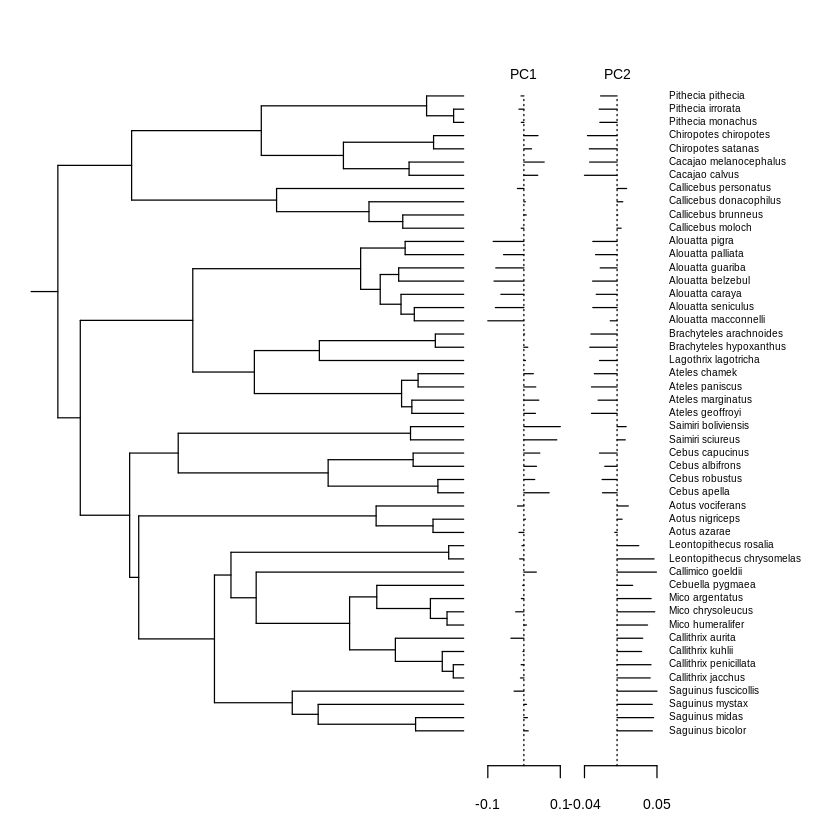

In [43]:
library(PhylogeneticEM)
library(ape)

data(monkeys) # and not just b/c you'll need to monkey around with l1ou later...

plot(params_BM(p = 2),
     data = monkeys$dat, phylo = monkeys$phy,
     show.tip.label = TRUE, cex = 0.5, no.margin = TRUE)

Bastide et al. (2018) set out as their goal to reconstruct transitions in multivariate space. Recall the point the point they make that the OU model is identical to a Brownian motion model with transformed data and transformed topology. We won't work out the data transformation here, but take a look how $\alpha$ enters into the OU model: by the rescaled branches alone. As a reminder:

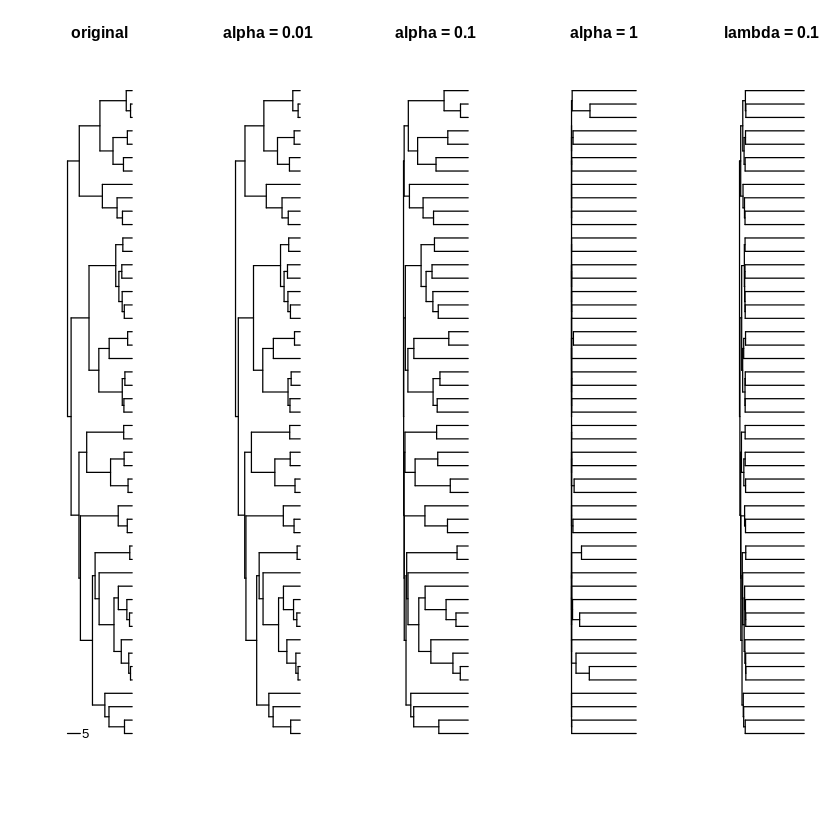

In [24]:
m0.01 <- transform_branch_length(monkeys$phy, 0.01)
m0.1 <- transform_branch_length(monkeys$phy, 0.1)
m1 <- transform_branch_length(monkeys$phy, 1)

# lay out a 5-panel plot
layout(matrix(1:5, 1))

#plot trees
plot(monkeys$phy, show.tip.label = F, main = 'original')
add.scale.bar()
plot(m0.01, show.tip.label = F, main = 'alpha = 0.01')
plot(m0.1, show.tip.label = F, main = 'alpha = 0.1')
plot(m1, show.tip.label = F, main = 'alpha = 1')

# and just for the heck of it, let's add a low-lambda tree
library(geiger)
mL0.1 <- rescale(monkeys$phy, 'lambda', 0.1)
plot(mL0.1, show.tip.label = F, main = 'lambda = 0.1')

In [28]:
library(doParallel) # not needed, but here as a reminder: if you have it, each value of alpha can be run on a separate core
res <- PhyloEM(phylo = monkeys$phy,
               Y_data = monkeys$dat,
               process = "scOU",                   ## scalar OU model
               random.root = TRUE,                 ## Root is stationary
               stationary.root = TRUE,
               nbr_alpha = 4,                      ## Number of alpha values tested (should be raised)
               K_max = 10,                         ## Maximal number of shifts
               parallel_alpha = TRUE,              ## This can be set to TRUE for parallel computations
               Ncores = 1)                         ## ... but I'm setting Ncores = 1 for tutorial b/c we're all on the same machine today
res

There are some equivalent solutions to the set of shifts selected by the BGHlsq method.
There are some equivalent solutions to the set of shifts selected by the BGHlsqraw method.
There are some equivalent solutions to the set of shifts selected by the BGHmlraw method.


Result of the PhyloEM algorithm.
Selected parameters by the default method:
2 dimensional scOU process with a random stationary root.

Root expectations:
[1]  0.01552091 -0.01483439

Root variance:
              [,1]          [,2]
[1,]  3.636791e-04 -9.031817e-05
[2,] -9.031817e-05  1.230269e-04

Process variance:
              [,1]          [,2]
[1,]  1.477757e-04 -3.669947e-05
[2,] -3.669947e-05  4.999019e-05

Process selection strength:
          [,1]      [,2]
[1,] 0.2031677 0.0000000
[2,] 0.0000000 0.2031677

Process root optimal values:
[1]  0.01552091 -0.01483439

Shifts positions on branches: 4, 63, 46 
Shifts values:
               4           63         46
[1,] -0.01812684 -0.093914264 0.08031859
[2,]  0.05234025 -0.008148889 0.02527294



See help to see all plotting and handling functions.

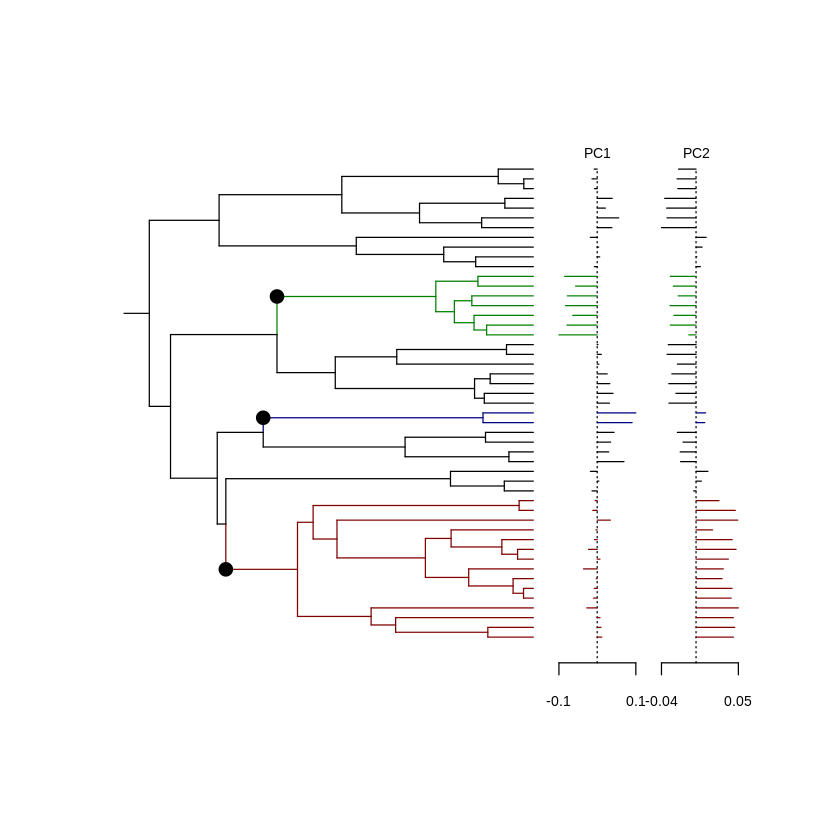

In [29]:
plot(res)

You have read the critique of `l1ou` for inferring shifts where traits are correlated; let's how it behaves.

In [40]:
library(l1ou)
monkey1 <- adjust_data(monkeys$phy, t(monkeys$dat))
res.l1ou <- estimate_shift_configuration(monkey1$tree, monkey1$Y, max.nShifts = 10)

the new tree edges are ordered differently: in postorder.
the new tree is normalized: each tip at distance 1 from the root.
Starting first LASSO (alpha=0) to find a list of candidate configurations.
Starting second LASSO (alpha= 0 0 ) for another list of candidates.


In [41]:
res.l1ou

number of shifts: 2
pBIC score: -518.6565
edge indices of the shift configuration (column names) and the corresponding shift values:
           61        89
PC1 -155070.9 -20229.26
PC2 3507157.1 422511.40

                                     PC1          PC2
adaptation rate (alpha)     1.131650e-06 1.284750e-07
variance (sigma2)           1.524451e-03 2.122147e-04
stationary variance (gamma) 6.735520e+02 8.258987e+02
logLik                      1.176445e+02 1.659533e+02


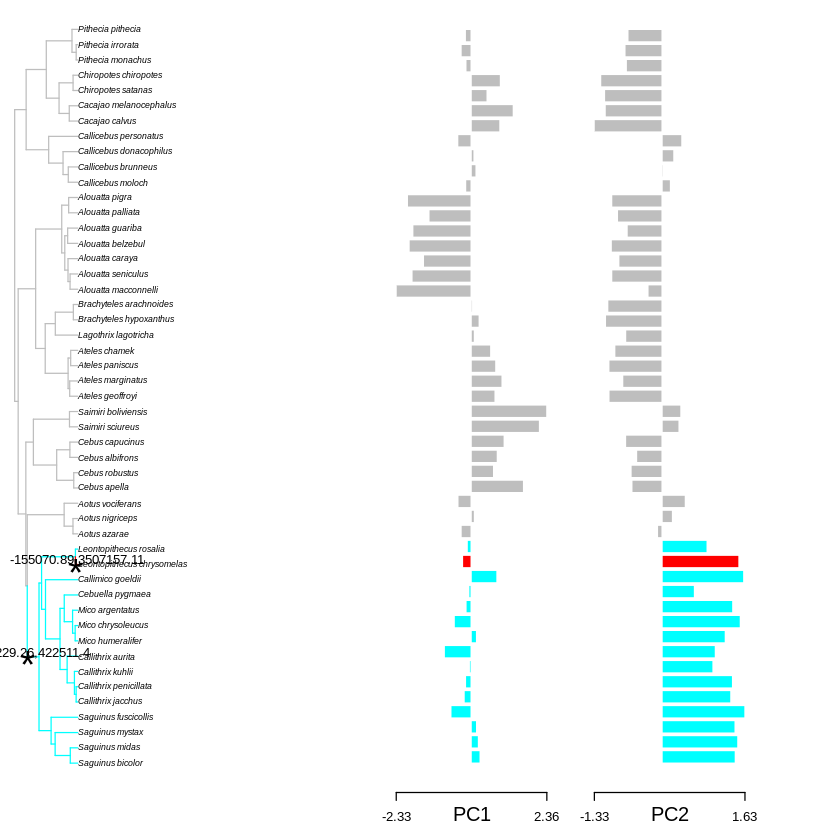

In [42]:
plot(res.l1ou)

So in this case, is the phylogenetic lasso approach implemented in `l1ou`, without consideration of dependence between traits, more sensitive or less sensitive than the Expectation - Maximization algorithm used in `PhylogeneticEM`, allow dependence between traits? Which do you think is appropriate, and why?

## Hypothesis testing with OU models
Now, you might be of the mindset that you'd rather test hypotheses defined _a prior_ than go a-fishin' for shifts. You have to be careful here. You _may not_ use `l1ou` or `PhylogeneticEM` to find a great configuration, then test those against other configurations: that's against the law. You have to define your hypotheses before you inspect the data.

But let's imagine (contrary to fact!) that we did so. Let's identify branches where we think there are shifts. First, plot the tree w/ yr branch numbers on them:

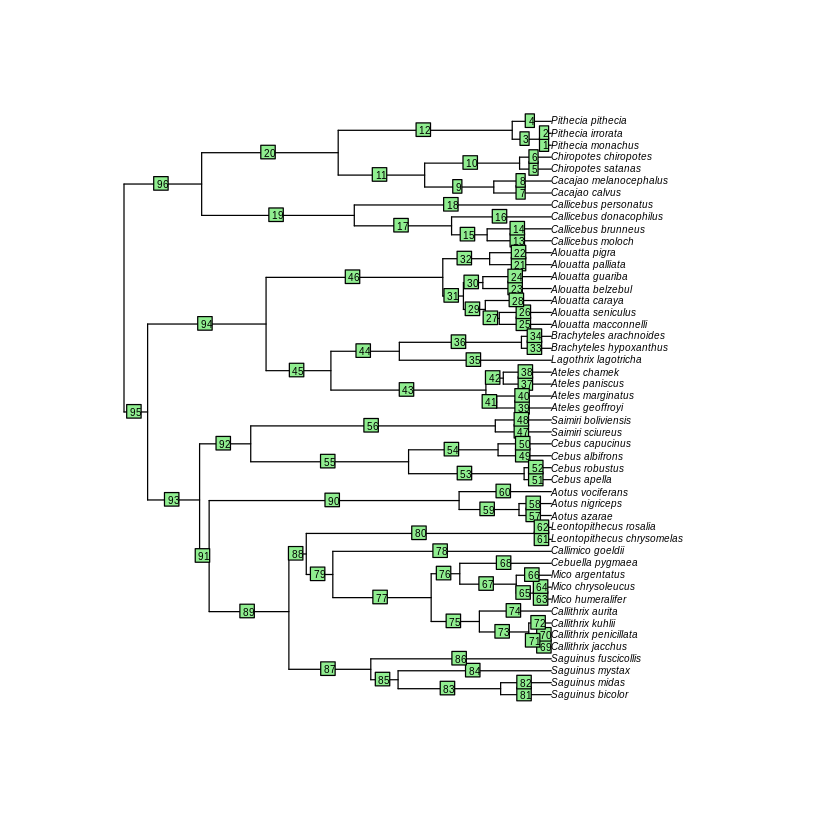

In [47]:
plot(monkey1$tree, cex = 0.5); edgelabels(cex = 0.5)

... and let's say we have, before we looked at the previous analyses, decided there are three plausible scenarios: (**h1**) a shift in secondary optimum on branch 89; (**h2**) a shift on branch 46; or (**h3**) a shift on both. (as a side-note, consider that we have no h-naught in this list; we are not in Neyman-Pearson mode here, but in the likelihoodist mode.) We can pit these against each other in `l1ou`. We will use the modified information criterion of [Khabbazian et al. 2016](http://dx.doi.org/10.1111/2041-210X.12534), which corrects for the increased complexity of multiple-change models.

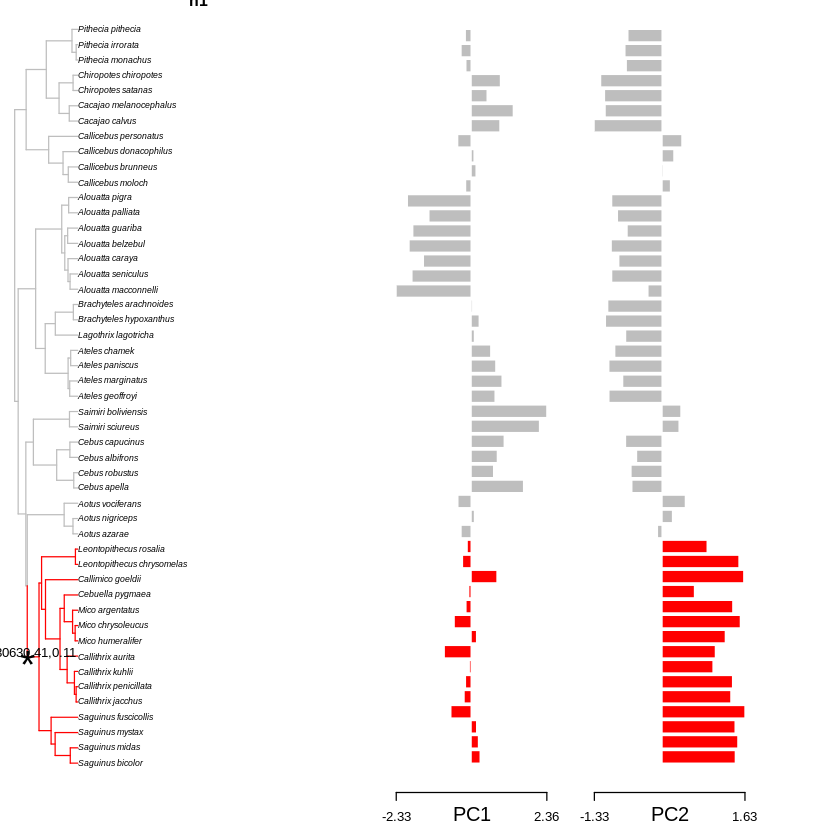

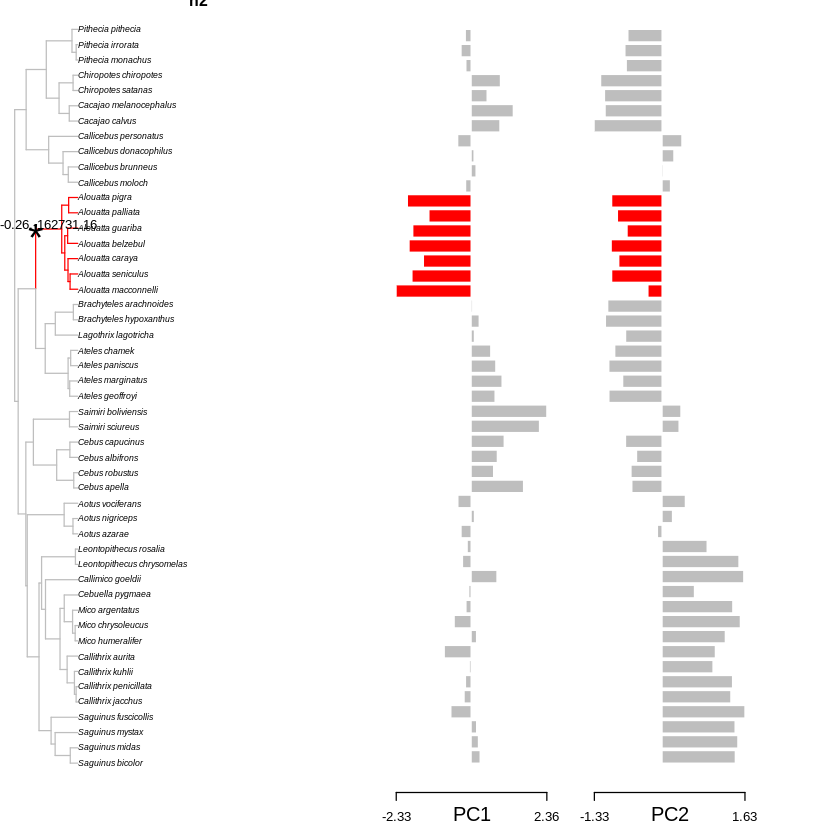

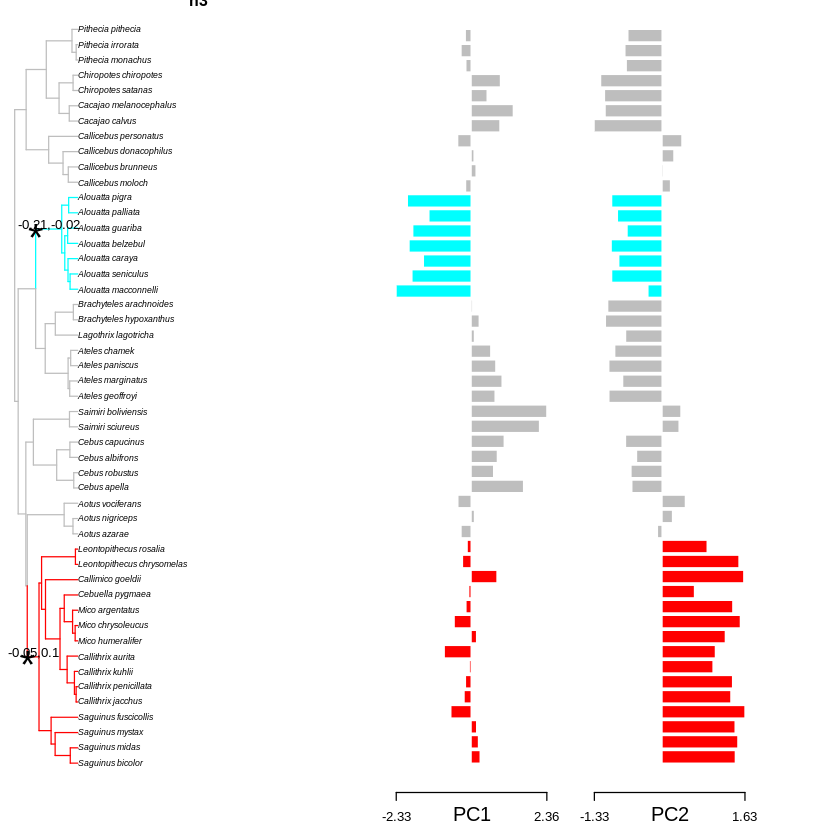

In [62]:
h1 <- fit_OU(monkey1$tree, monkey1$Y, 89, criterion = 'pBIC')
h2 <- fit_OU(monkey1$tree, monkey1$Y, 46, criterion = 'pBIC')
h3 <- fit_OU(monkey1$tree, monkey1$Y, c(46,89), criterion = 'pBIC')

plot(h1, main = 'h1')
plot(h2, main = 'h2')
plot(h3, main = 'h3')

... so we've checked our hypotheses. Let's see who wins:

In [64]:
message('H1---------------')
h1
message('H2---------------')
h2
message('H3---------------')
h3

H1---------------


number of shifts: 1
pBIC score: -519.5363
edge indices of the shift configuration (column names) and the corresponding shift values:
               89
PC1 -3.063041e+04
PC2  1.140788e-01

                                     PC1          PC2
adaptation rate (alpha)     7.729406e-07 6.578804e-01
variance (sigma2)           1.536352e-03 3.582379e-04
stationary variance (gamma) 9.938358e+02 2.722667e-04
logLik                      1.174539e+02 1.589773e+02


H2---------------


number of shifts: 1
pBIC score: -516.2837
edge indices of the shift configuration (column names) and the corresponding shift values:
               46
PC1 -2.625593e-01
PC2 -1.627312e+05

                                     PC1          PC2
adaptation rate (alpha)     6.416586e-01 1.008790e-07
variance (sigma2)           1.600446e-03 3.730856e-04
stationary variance (gamma) 1.247116e-03 1.849173e+03
logLik                      1.221671e+02 1.521302e+02


H3---------------


number of shifts: 2
pBIC score: -517.0867
edge indices of the shift configuration (column names) and the corresponding shift values:
            46          89
PC1 -0.2141863 -0.05023485
PC2 -0.0193310  0.10389046

                                     PC1          PC2
adaptation rate (alpha)     8.878995e-01 7.335799e-01
variance (sigma2)           1.672921e-03 3.646027e-04
stationary variance (gamma) 9.420668e-04 2.485092e-04
logLik                      1.231326e+02 1.591832e+02


It's not surprising, since we're using `l1ou` to do this, that the configuration selected automatically is the best of the three that we checked. But we can see that the configuration selected by `PhylogeneticEM` is not significantly worse. 